In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['mp-2-resize']
/kaggle/input/mp-2-resize ['CleanDataset']
/kaggle/input/mp-2-resize/CleanDataset ['Resized_Images']
/kaggle/input/mp-2-resize/CleanDataset/Resized_Images []


In [4]:
df = pd.read_csv('/kaggle/input/mp-2-resize/CleanDataset/clean_and_merged_df.csv')

# Define the image directory
image_dir = '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images'

# Append the full path to imageid column
df['imageid'] = df['imageid'].apply(lambda x: os.path.join(image_dir, x))

In [5]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['glaucoma'], random_state=42)

In [6]:
# Rename 'glaucoma' column to 'target' in both dataframes
train_df.rename(columns={'glaucoma': 'target'}, inplace=True)
val_df.rename(columns={'glaucoma': 'target'}, inplace=True)

# Update the labels to 'normal' for 0 and 'glaucoma' for 1
train_df['target'] = train_df['target'].replace({0: 'normal', 1: 'glaucoma'})
val_df['target'] = val_df['target'].replace({0: 'normal', 1: 'glaucoma'})

In [7]:
train_df

,imageid,target
849,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
340,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
313,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
295,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
1805,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
...,...,...
2547,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
343,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
605,/kaggle/input/mp-2-resize/CleanDataset/Resized...,glaucoma
299,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal


In [8]:
val_df

,imageid,target
616,/kaggle/input/mp-2-resize/CleanDataset/Resized...,glaucoma
1216,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
612,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
1308,/kaggle/input/mp-2-resize/CleanDataset/Resized...,glaucoma
1557,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
...,...,...
1571,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
2300,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
426,/kaggle/input/mp-2-resize/CleanDataset/Resized...,normal
386,/kaggle/input/mp-2-resize/CleanDataset/Resized...,glaucoma


In [9]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define your target classes
class_mapping = {'normal': 0, 'glaucoma': 1}

# Create training and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='imageid',
    y_col='target',
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='imageid',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

Found 2056 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


In [10]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'normal': 0, 'glaucoma': 1}
{'normal': 0, 'glaucoma': 1}


In [11]:
# Function to print all information of a generator
def print_generator_info(generator, name='Generator'):
    print(f"\nInformation for {name}:")
    print(f"Class Indices: {generator.class_indices}")  # Class labels and their corresponding indices
    print(f"Classes: {generator.classes[:10]}")  # Display the first 10 class labels (encoded as integers)
    print(f"Batch Size: {generator.batch_size}")  # Batch size used in the generator
    print(f"Image Shape: {generator.image_shape}")  # Shape of the images fed into the model
    print(f"Total Samples: {generator.samples}")  # Total number of samples in the generator
    print(f"Steps Per Epoch: {generator.n}")  # Number of steps (batches) per epoch
    print(f"Target Size: {generator.target_size}")  # Target size of the images after resizing
    print(f"Color Mode: {generator.color_mode}")  # Color mode (e.g., 'rgb', 'grayscale')
    print(f"Shuffle: {generator.shuffle}")  # Whether the data is shuffled
    print(f"First 5 File Paths: {generator.filepaths[:5]}")  # First 5 file paths of the images

In [12]:
# Print information for both train_generator and val_generator
print_generator_info(train_generator, name='Train Generator')



Information for Train Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Batch Size: 32
Image Shape: (224, 224, 3)
Total Samples: 2056
Steps Per Epoch: 2056
Target Size: (224, 224)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2695.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1165.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1034.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_953.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/n0096.jpg']


In [13]:
print_generator_info(val_generator, name='Validation Generator')


Information for Validation Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Batch Size: 32
Image Shape: (224, 224, 3)
Total Samples: 515
Steps Per Epoch: 515
Target Size: (224, 224)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2035.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/197.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2031.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/289.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/538.jpg']


In [14]:
# Print total number of images in train and validation generators
print(f"Total images in train_generator: {train_generator.samples}")
print(f"Total images in val_generator: {val_generator.samples}")


Total images in train_generator: 2056
Total images in val_generator: 515


In [30]:
# Step 1: Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Fine-tuning - Unfreeze some layers of the VGG16 base model
# Unfreeze the last few convolutional blocks of the VGG16 model
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True

# Define the model by adding custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(1, activation='sigmoid')(x)  # For binary classification

model = Model(inputs=base_model.input, outputs=x)

# Step 3: Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 13,004,289 (49.61 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [32]:
# [train the model]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [33]:
# Train the entire model again, with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=50,  # Fine-tune for more epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 423ms/step - accuracy: 0.6804 - loss: 0.5953 - val_accuracy: 0.7612 - val_loss: 0.5171 - learning_rate: 1.0000e-05
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.7528 - loss: 0.5312 - val_accuracy: 0.7612 - val_loss: 0.5573 - learning_rate: 1.0000e-05
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 395ms/step - accuracy: 0.7812 - loss: 0.4973 - val_accuracy: 0.7534 - val_loss: 0.4893 - learning_rate: 1.0000e-05
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.7692 - loss: 0.4948 - val_accuracy: 0.7650 - val_loss: 0.4712 - learning_rate: 1.0000e-05
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.7706 - loss: 0.4974 - val_accuracy: 0.7670 - val_loss: 0.4732 - learning_rate: 1.0000e-05
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.7652 - loss: 0.5021 - val_accuracy: 0.7689 - val_loss: 0.4497 - learning_rate: 1.0000e-05
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - acc

In [34]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss after fine-tuning: {loss}')
print(f'Validation Accuracy after fine-tuning: {accuracy}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8035 - loss: 0.4038
Validation Loss after fine-tuning: 0.3958973288536072
Validation Accuracy after fine-tuning: 0.8019417524337769


In [35]:
# Get predictions for the validation set
y_pred_probs = model.predict(val_generator)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = val_generator.classes  # True classes


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get predictions
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.round(y_pred_probs).astype(int)  # For binary classification

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
Precision: 0.25
Recall: 0.14
F1 Score: 0.18
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       392
           1       0.25      0.14      0.18       123

    accuracy                           0.69       515
   macro avg       0.50      0.50      0.49       515
weighted avg       0.64      0.69      0.66       515

Confusion Matrix:
 [[340  52]
 [106  17]]


In [37]:
from sklearn.metrics import roc_auc_score

# No need to slice, just use y_pred_probs directly
auc_roc = roc_auc_score(y_true_classes, y_pred_probs)  # y_pred_probs is already (n_samples,)
print(f'AUC-ROC: {auc_roc:.2f}')

AUC-ROC: 0.50


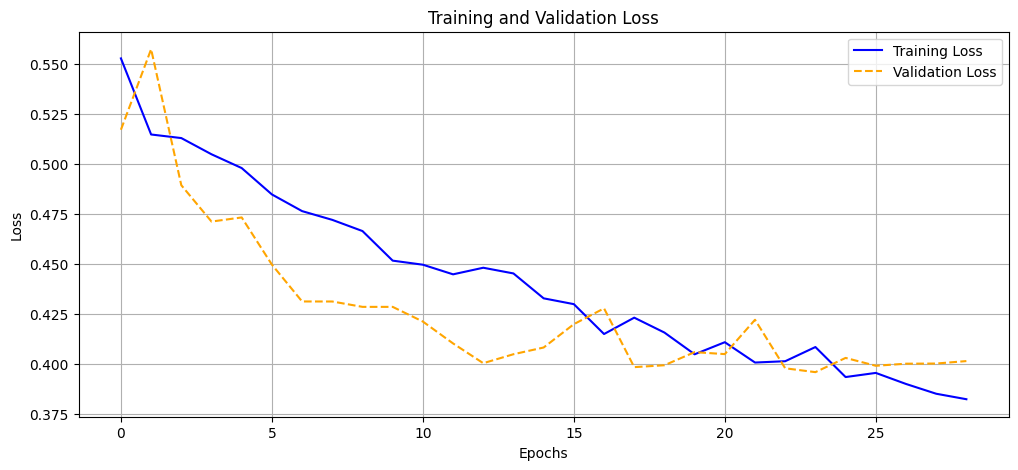

In [38]:
# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))

# Training Loss
plt.plot(history_finetune.history['loss'], label='Training Loss', color='blue', linestyle='-')
# Validation Loss
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

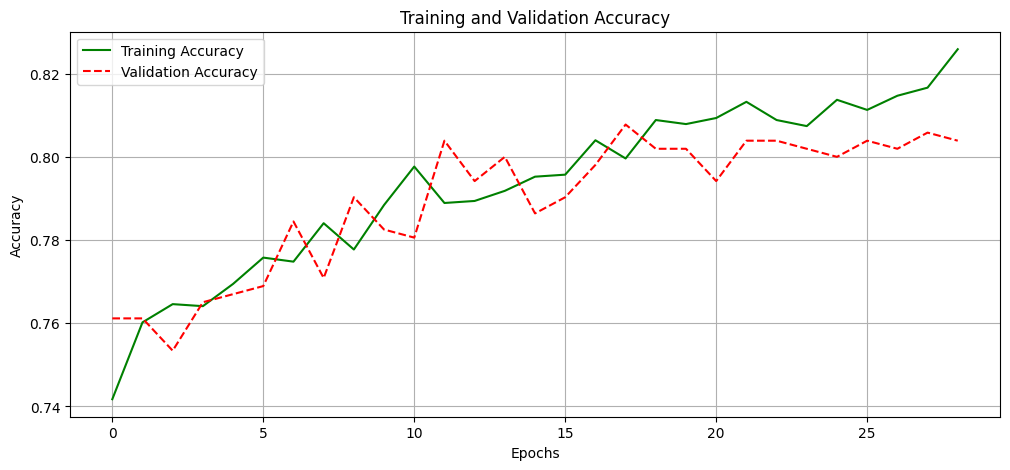

In [40]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training Accuracy
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
# Validation Accuracy
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
model.save('/kaggle/working/MP_VGG16-FineTunning-Modified-V3.keras')

In [44]:
model.save('/kaggle/working/MP_VGG16-FineTunning-Modified-V3.h5')